# GHP Cpnstruction with Duration Matching

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
erk.bond_cash_flows(3,100,0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [4]:
erk.bond_price(20, 1000, 0.05,2,0.04)

1136.7773962036904

In [5]:
erk.bond_price(20, 1000, 0.05,2,0.05)

1000.0000000000023

In [6]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [8]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

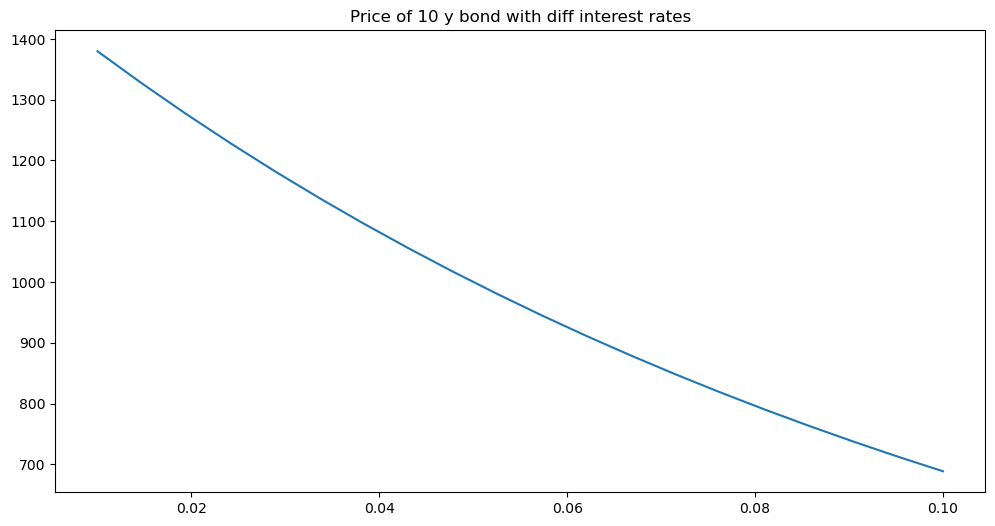

In [11]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10 y bond with diff interest rates", legend=False, figsize=(12,6))
plt.show()

In [12]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [14]:
discounts = erk.discount(cf.index,0.06/2)
discounts

Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
       0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
      dtype='float64')

In [16]:
dcf = discounts * cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [17]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [18]:
(cf.index * weights).sum()

5.579707187194534

In [19]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

# Duarion Matching
If you can match the Macaulay duration of the cash flow with the one of the liability, you can get a portfolio which have a same sensityvity as the liability

In [20]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [21]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1),0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1),0.04)

In [22]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

In this case, we need to set the weight to match the duration of the portfolio with the one of the liability.

So that we need to find $w_s$ which satisfies
$$w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96$$
In general, 
$$w_s \times d_s + (1-w_s) \times d_l = d_t$$
where $d_s, d_l$ and $d_t$ are the durations of a short bond, a long bond and a liability.

Therefore, we get
$$w_s = \frac{d_l - d_t}{d_l-d_s}$$


In [25]:
short_bond = erk.bond_cash_flows(10,1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20,1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [27]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000
p_flows = pd.concat([a_0 * w_s * short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)


10.960799385088393